In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [83]:
df = pd.read_csv('data.csv')
df['correct'] = (df.true == df.pred)
df['(true=1,pred=1)'] = (df.true == 1) &  (df.pred == 1)
df['(true=1,pred=0)'] = (df.true == 1) &  (df.pred == 0)
df['(true=0,pred=1)'] = (df.true == 0) &  (df.pred == 1)
df['(true=0,pred=0)'] = (df.true == 0) &  (df.pred == 0)
df['expert'] = df.index >= 6516
df = df[df.gender.isin(['male', 'female'])]

df[:6]

,id,expt_id,duration,true,pred,age,gender,filename,correct,"(true=1,pred=1)","(true=1,pred=0)","(true=0,pred=1)","(true=0,pred=0)",expert
0,1,1,5000,1,1,20,male,real/real-45.jpg,True,True,False,False,False,False
1,2,1,5000,0,0,20,male,gan/gan-7.jpg,True,False,False,False,True,False
2,3,1,5000,1,0,20,male,real/real-25.jpg,False,False,True,False,False,False
3,4,1,5000,0,0,20,male,gan/gan-31.jpg,True,False,False,False,True,False
4,5,1,5000,0,0,20,male,gan/gan-11.jpg,True,False,False,False,True,False
5,6,1,5000,1,1,20,male,real/real-5.jpg,True,True,False,False,False,False


In [84]:
# df = df[:6516] #No-ML
# df = df[6516:] #Yes-ML
print (df.shape)

(254370, 14)


In [85]:
df.groupby(["expt_id", "duration"]).true.mean()

expt_id  duration
1        250         0.501103
         500         0.501061
         1000        0.502372
         2000        0.501025
         5000        0.496378
2        250         0.498714
         500         0.505238
         1000        0.497981
         2000        0.503625
         5000        0.496325
Name: true, dtype: float64

In [86]:
dur1 = 5000
dur2 = 5000
g1 = 'male'
g2 = 'female'
e1 = True
e2 = True
id1 = 2
id2 = 2
exp1_data = df[(df.expt_id==id1) & (df.duration==dur1) & (df.gender==g1) & (df.expert==e1)].correct
exp2_data = df[(df.expt_id==id2) & (df.duration==dur2) & (df.gender==g2) & (df.expert==e2)].correct

print (exp1_data.mean())
print (exp2_data.mean())


from scipy.stats import ttest_ind

print (ttest_ind(exp1_data, exp2_data))

0.6885766092475069
0.6730052199850858
Ttest_indResult(statistic=1.584358054718001, pvalue=0.11313212907180265)


In [87]:
indiv_df = df.groupby(by=lambda x: x//6, axis=0).agg({
    'expt_id': 'max',
    'duration': 'max',
    'age': 'max',
    'gender': 'max',
    'expert': 'max',
    'id': 'nunique',
    'true': 'sum',
    'correct': 'mean',
    '(true=1,pred=1)': 'sum',
    '(true=1,pred=0)': 'sum',
    '(true=0,pred=1)': 'sum',
    '(true=0,pred=0)': 'sum',
})


indiv_df['accuracy'] = indiv_df.correct
indiv_df['(pred=1|true=1)'] = indiv_df['(true=1,pred=1)'] / indiv_df['true']
indiv_df['(pred=0|true=1)'] = indiv_df['(true=1,pred=0)'] / indiv_df['true']
indiv_df['(pred=1|true=0)'] = indiv_df['(true=0,pred=1)'] / (6 - indiv_df['true'])
indiv_df['(pred=0|true=0)'] = indiv_df['(true=0,pred=0)'] / (6 - indiv_df['true'])

indiv_df = indiv_df[[
    'expt_id',
    'duration',
    'age',
    'gender',
    'expert',
    'id',
    'true',
    'accuracy',
    '(pred=1|true=1)',
    '(pred=0|true=1)',
    '(pred=1|true=0)',
    '(pred=0|true=0)',
]]

indiv_df.head()

,expt_id,duration,age,gender,expert,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0)
0,1,5000,20,male,False,6,3,0.833333,0.666667,0.333333,0.000000,1.000000
1,1,2000,20,male,False,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
2,1,1000,20,male,False,6,3,0.500000,1.000000,0.000000,1.000000,0.000000
3,1,500,20,male,False,6,3,0.500000,0.666667,0.333333,0.666667,0.333333
4,1,250,20,male,False,6,3,0.333333,0.666667,0.333333,1.000000,0.000000


In [88]:
def conf_interval(N, p_success):
    return (1.96/N)*np.sqrt(p_success*(1-p_success)*N) #90% conf interval


def get_results(df, columns):
    results = df.groupby(columns).agg({
        'id': 'sum',
        'true': 'sum',
        'accuracy': 'mean',
        '(pred=1|true=1)': 'mean',
        '(pred=0|true=1)':'mean',
        '(pred=1|true=0)': 'mean',
        '(pred=0|true=0)': 'mean',
    }).reset_index()
    
    results['accuracy_conf'] = conf_interval(results.id, results.accuracy)
    results['(pred=1|true=1)_conf'] = conf_interval(results.true, results['(pred=1|true=1)'])
    results['(pred=0|true=1)_conf'] = conf_interval(results.true, results['(pred=0|true=1)'])
    results['(pred=1|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=1|true=0)'])
    results['(pred=0|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=0|true=0)'])

    return results

indiv_results = get_results(indiv_df, ['expt_id', 'duration'])
indiv_expert_results = get_results(indiv_df, ['expert', 'expt_id', 'duration'])
indiv_gender_results = get_results(indiv_df, ['expt_id', 'duration', 'gender'])
indiv_expert_gender_results = get_results(indiv_df, ['expert', 'expt_id', 'duration', 'gender'])


indiv_expert_results[(indiv_expert_gender_results.expert==True) & (indiv_expert_gender_results.gender=='female')]

/home/abhinav/Documents/meng/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,expert,expt_id,duration,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),accuracy_conf,(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf


In [89]:
indiv_expert_results

,expert,expt_id,duration,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),accuracy_conf,(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf
0,False,1,250,786,395,0.549618,0.599618,0.400382,0.498718,0.501282,0.034783,0.048321,0.048321,0.049561,0.049561
1,False,1,500,828,418,0.617150,0.615580,0.384420,0.376471,0.623529,0.033109,0.046635,0.046635,0.046898,0.046898
2,False,1,1000,870,442,0.611494,0.544368,0.455632,0.321096,0.678904,0.032389,0.046430,0.046430,0.044234,0.044234
3,False,1,2000,960,482,0.636458,0.621146,0.378854,0.332075,0.667925,0.030429,0.043308,0.043308,0.042221,0.042221
4,False,1,5000,1260,617,0.652381,0.606858,0.393142,0.284206,0.715794,0.026295,0.038542,0.038542,0.034863,0.034863
5,False,2,250,324,173,0.500000,0.519497,0.480503,0.504630,0.495370,0.054444,0.074451,0.074451,0.079748,0.079748
6,False,2,500,324,163,0.570988,0.471605,0.528395,0.347170,0.652830,0.053893,0.076636,0.076636,0.073538,0.073538
7,False,2,1000,336,163,0.556548,0.501786,0.498214,0.386905,0.613095,0.053120,0.076759,0.076759,0.072577,0.072577
8,False,2,2000,336,167,0.562500,0.496131,0.503869,0.343155,0.656845,0.053044,0.075832,0.075832,0.071580,0.071580
9,False,2,5000,408,204,0.600490,0.595833,0.404167,0.390686,0.609314,0.047527,0.067342,0.067342,0.066954,0.066954


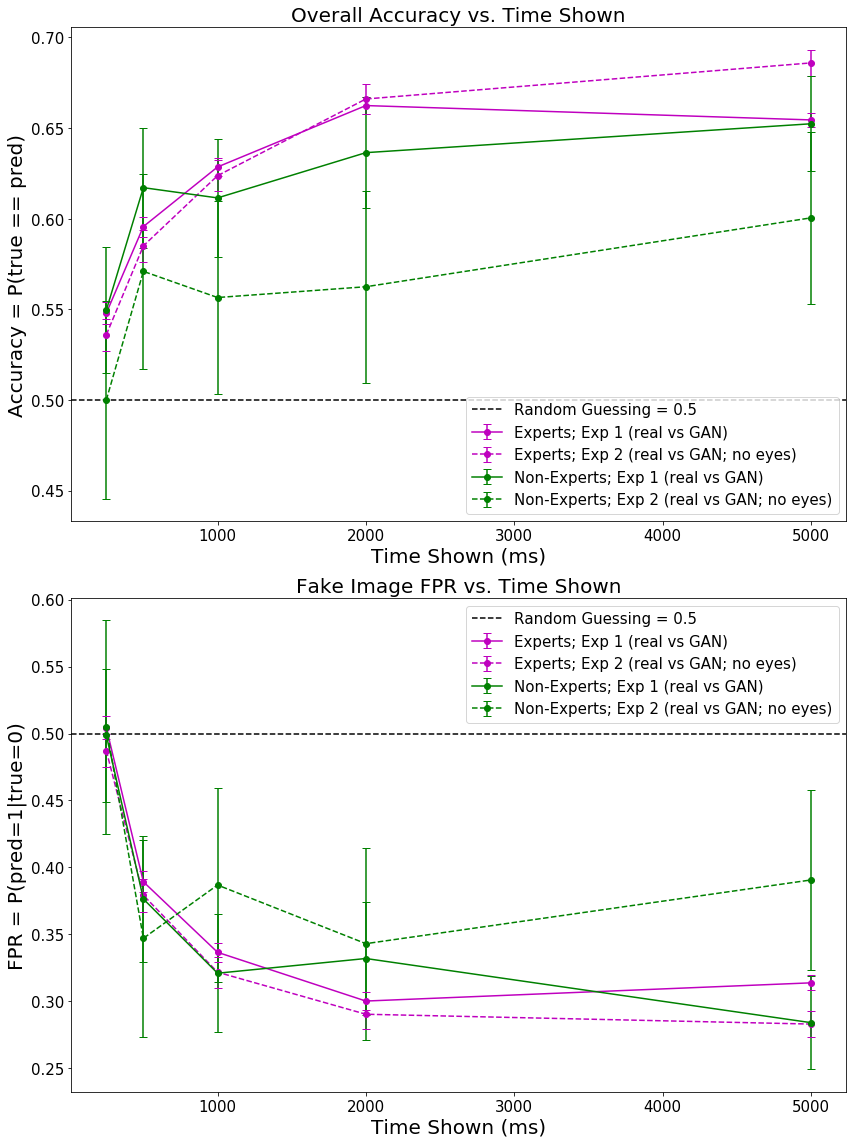

In [93]:
fig = plt.figure(figsize=(12,16))
fs = 20
tfs = 15
ax1 = fig.add_subplot(211)
ax1.set_title("Overall Accuracy vs. Time Shown", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = [
    (1, "Experts; Exp 1 (real vs GAN)", "m", "-", True), 
    (2, "Experts; Exp 2 (real vs GAN; no eyes)", "m", "--", True),
    (1, "Non-Experts; Exp 1 (real vs GAN)", "g", "-", False), 
    (2, "Non-Experts; Exp 2 (real vs GAN; no eyes)", "g", "--", False)
]

for (expt_id, label, color, linestyle, expert)  in id_map:
    exp_data = indiv_expert_results[(indiv_expert_results.expt_id == expt_id) & (indiv_expert_results.expert == expert)]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

#     exp_data = results[results.expt_id == expt_id]
#     ax1.plot(exp_data.duration, exp_data.accuracy, color=color, linestyle=linestyle, marker='o', label=label)
#     ax2.plot(exp_data.duration, exp_data['(pred=1|true=0)'], color=color, linestyle=linestyle, marker='o', label=label)
    
#     print (exp_data.accuracy)

ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('overall_acc.png')
plt.tight_layout()
plt.show()

1) Overall, what is the distribution of real vs. fake responses per duration
2) What are the component of the error (FPR, FNR)
3) When eyes are removed, do people think images are fake more often

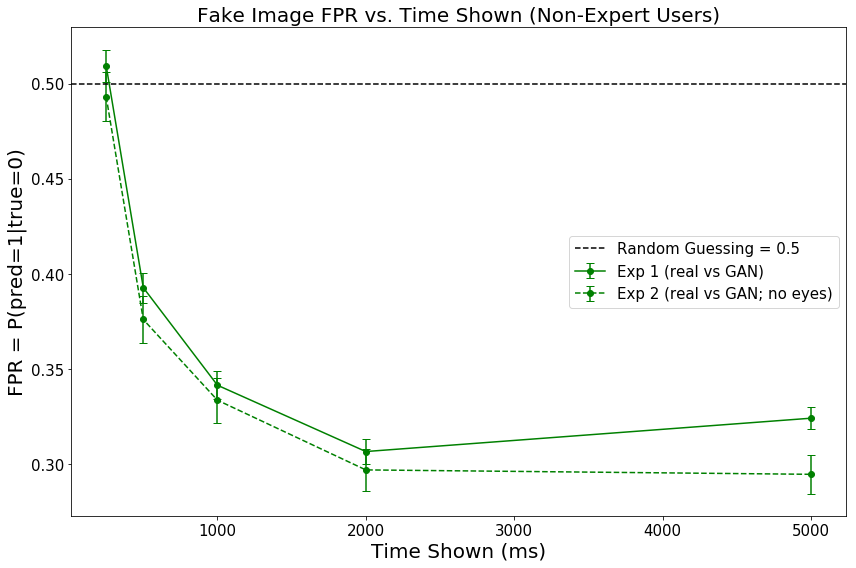

In [9]:
fig = plt.figure(figsize=(12,8))
fs = 20
tfs = 15
# ax1 = fig.add_subplot(111)
# ax1.set_title("Overall Accuracy vs. Time Shown (Non-Expert Users)", fontsize=fs)
# ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
# ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(111)
ax2.set_title("Fake Image FPR vs. Time Shown (Non-Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = {
    1:("Exp 1 (real vs GAN)", "g", "-"), 
    2:("Exp 2 (real vs GAN; no eyes)", "g", "--")
}

for expt_id, (label, color, linestyle)  in id_map.items():
    exp_data = indiv_results[indiv_results.expt_id == expt_id]
#     ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
#                  color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

#     exp_data = results[results.expt_id == expt_id]
#     ax1.plot(exp_data.duration, exp_data.accuracy, color=color, linestyle=linestyle, marker='o', label=label)
#     ax2.plot(exp_data.duration, exp_data['(pred=1|true=0)'], color=color, linestyle=linestyle, marker='o', label=label)
    
#     print (exp_data.accuracy)

# ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
# ax1.legend(loc=0, fontsize=tfs)
# ax1.xaxis.set_tick_params(labelsize=tfs)
# ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('overall_fpr_nonexpert.png')
plt.tight_layout()
plt.show()

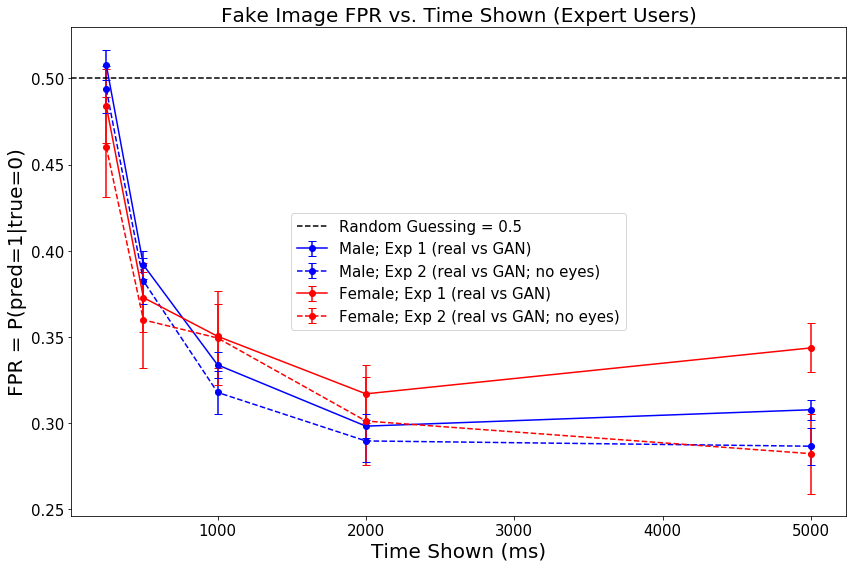

In [95]:
fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(111)
# ax1.set_title("Face Classification Overall Accuracy vs. Time Shown (Expert Users)", fontsize=fs)
# ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
# ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)

ax2 = fig.add_subplot(111)
ax2.set_title("Fake Image FPR vs. Time Shown (Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

gender_id_map = {
    ('male', 1):("Male; Exp 1 (real vs GAN)", "b", "-"), 
    ('male', 2):("Male; Exp 2 (real vs GAN; no eyes)", "b", "--"),
    ('female', 1):("Female; Exp 1 (real vs GAN)", "r", "-"), 
    ('female', 2):("Female; Exp 2 (real vs GAN; no eyes)", "r", "--")
}

for (gender, expt_id), (label, color, linestyle)  in gender_id_map.items():
    exp_data = indiv_gender_results[(indiv_gender_results.gender == gender) & (indiv_gender_results.expt_id == expt_id)]
#     ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
#                  color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)


# ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
# ax1.legend(loc=0, fontsize=tfs)
# ax1.xaxis.set_tick_params(labelsize=tfs)
# ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('gender_overall_fpr_expert_exp2.png')
plt.tight_layout()
plt.show()

In [94]:
print ("Exp 1, # datapoints: %d" % df[df.expt_id==1].id.count())
print ("Exp 2, # datapoints: %d" % df[df.expt_id==2].id.count())
print ("---------------------------------------------")
print(indiv_df[indiv_df.gender != 'other'].groupby(["expt_id", "duration"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))
print(indiv_df[indiv_df.gender != 'other'].groupby(["expt_id", "duration", "gender"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))

Exp 1, # datapoints: 186606
Exp 2, # datapoints: 67764
---------------------------------------------
   expt_id  duration    id
4        1      5000  9204
3        1      2000  6339
2        1      1000  5691
1        1       500  5182
0        1       250  4685
9        2      5000  2721
8        2      2000  2253
7        2      1000  2146
6        2       500  2100
5        2       250  2074
    expt_id  duration  gender    id
8         1      5000  female  1400
9         1      5000    male  7804
6         1      2000  female   976
7         1      2000    male  5363
4         1      1000  female   856
5         1      1000    male  4835
2         1       500  female   763
3         1       500    male  4419
0         1       250  female   695
1         1       250    male  3990
18        2      5000  female   481
19        2      5000    male  2240
16        2      2000  female   414
17        2      2000    male  1839
14        2      1000  female   390
15        2      1000    m

In [820]:
img_df = df.groupby('filename').agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
img_df['accuracy'] = img_df.correct / img_df.id



gender_img_df = df.groupby(['filename', 'gender']).agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
gender_img_df['accuracy'] = gender_img_df.correct / gender_img_df.id

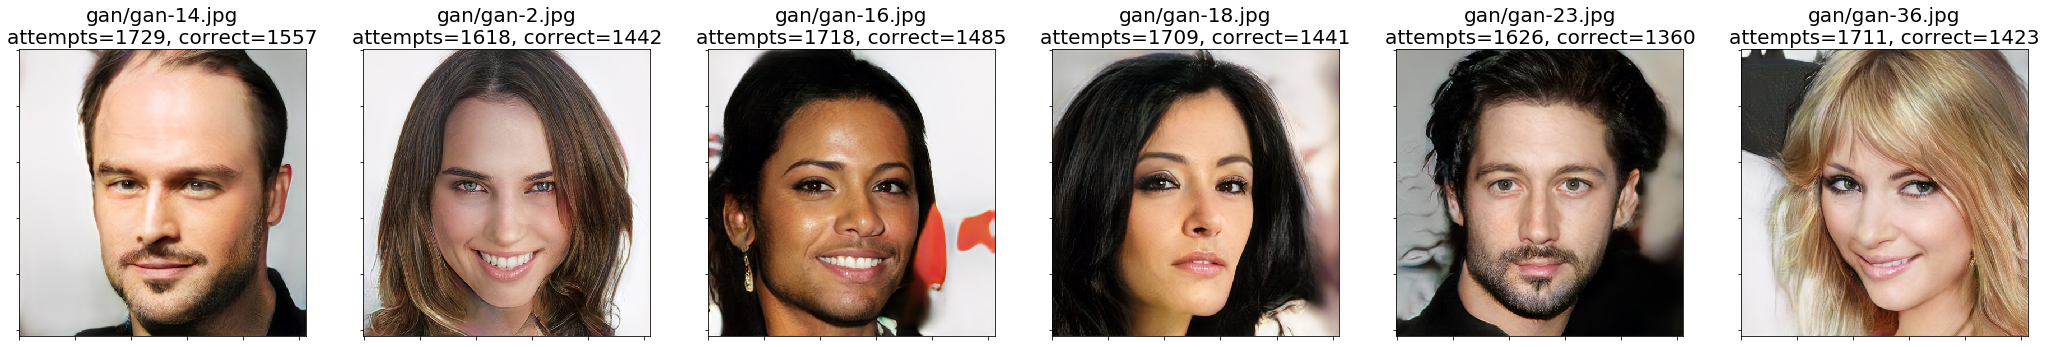

In [821]:
N = 6
expt_id = 1
true = 0
ascending = False

fs = 20

data = img_df[(img_df.true == true) & (img_df.expt_id == expt_id)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

# plt.hist(data.accuracy, bins=10)
# plt.show()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])), fontsize=fs)
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# fig.savefig('./final_plots/easy_fake_exp1_expert.png')
plt.show()

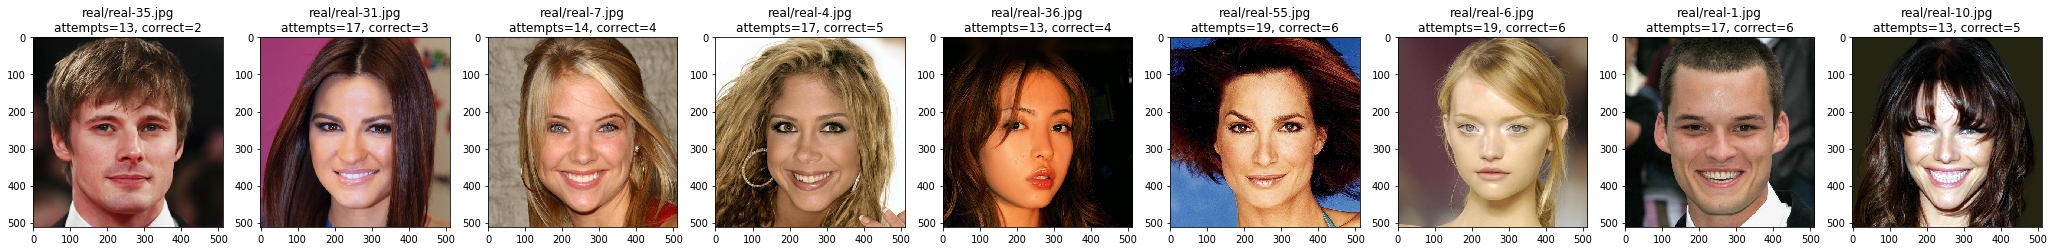

In [728]:
N = 9
true = 1
expt_id = 1
ascending = True
gender = 'female'

data = gender_img_df[(gender_img_df.true == true) & (gender_img_df.expt_id == expt_id) & (gender_img_df.gender == gender)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))

plt.show()

/home/abhinav/Documents/meng/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


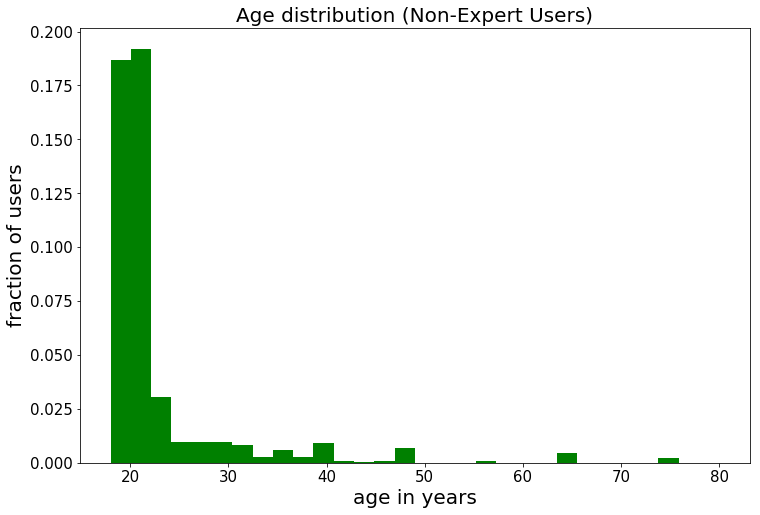

In [729]:
fs = 20
tfs = 15
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title("Age distribution (Non-Expert Users)", fontsize=fs)
ax.set_xlabel("age in years", fontsize=fs)
ax.set_ylabel("fraction of users", fontsize=fs)
ax.hist(df.age, bins=30, range=(18,80), color="g", normed=True)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)
# fig.savefig('age_nonexpert.png')
plt.show()

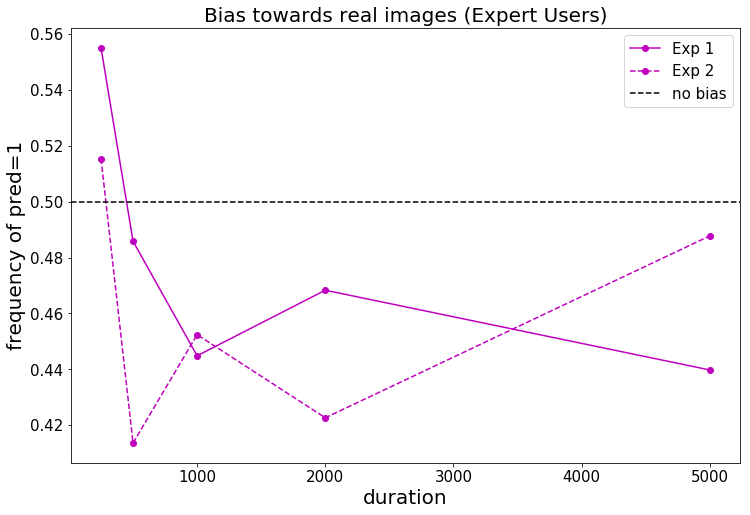

In [730]:
bias_df = df.groupby(['expt_id', 'duration']).pred.mean().reset_index()

fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for expt_id, style in [(1, '-'),(2, '--')]:
    data = bias_df[bias_df.expt_id == expt_id].sort_values(by="duration", ascending=True)
    ax.plot(data.duration, data.pred, color='m', marker="o", linestyle=style, label="Exp %d" % expt_id)
    
ax.axhline(y=0.5, color="k", linestyle="--", label="no bias")
ax.set_title("Bias towards real images (Expert Users)", fontsize=fs)
ax.set_xlabel("duration", fontsize=fs)
ax.set_ylabel("frequency of pred=1", fontsize=fs)
ax.legend(loc=0, fontsize=tfs)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)

fig.savefig('bias_expert.png')
plt.show()    


,expt_id,duration,age,gender,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0)
0,1,5000,20,male,6,3,0.833333,0.666667,0.333333,0.000000,1.000000
1,1,2000,20,male,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
2,1,1000,20,male,6,3,0.500000,1.000000,0.000000,1.000000,0.000000
3,1,500,20,male,6,3,0.500000,0.666667,0.333333,0.666667,0.333333
4,1,250,20,male,6,3,0.333333,0.666667,0.333333,1.000000,0.000000
5,1,5000,21,male,6,3,1.000000,1.000000,0.000000,0.000000,1.000000
6,1,2000,21,male,6,3,0.666667,0.666667,0.333333,0.333333,0.666667
7,1,5000,20,female,6,3,0.500000,0.333333,0.666667,0.333333,0.666667
8,1,2000,20,female,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
9,1,1000,20,female,6,3,0.666667,0.666667,0.333333,0.333333,0.666667
